# Imports

In [1]:
# !pip install torchviz

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models
import pandas as pd
import os
from PIL import Image
from torch.utils.data import TensorDataset,Dataset, DataLoader



# Data preparation and loading

In [2]:
labels = pd.read_csv('/kaggle/input/sctdataset/reducedData/reducedData/labels.csv')
labels.columns

Index(['PositionImage_FileName', 'Room Ligiting', 'Both hands on table?',
       'Can able to see student along with full table?',
       'Computer Screen Visible?', 'Final Decision for uploaded Image'],
      dtype='object')

In [3]:
labels

,PositionImage_FileName,Room Ligiting,Both hands on table?,Can able to see student along with full table?,Computer Screen Visible?,Final Decision for uploaded Image
0,Screenshot20240930123634AnshuSharmapng.jpg,Dark,No,No,No,Rejected
1,SCT22F3002578PESALAVENKATAABHINAVCHAITANYApng.jpg,Dark,No,No,No,Rejected
2,23f3000462dixitDixitpng.jpg,Dark,No,No,No,Rejected
3,Screenshot3SIVASUNDARIRpng.jpg,Dark,No,No,No,Rejected
4,SCTMSENTHILKUMARpng.jpg,Dark,No,No,No,Rejected
...,...,...,...,...,...,...
987,SCT24F100063324F1000633ROHITKUMARSHAWpng.jpg,Visible,Yes,Yes,Yes,Rejected
988,iitmANKITJANGIDjpg.jpg,Visible,Yes,Yes,Yes,Rejected
989,sctpositioningSNEHASINGHjpg.jpg,Visible,Yes,Yes,Yes,Rejected
990,SCT23F1000208SANTOSHKUMARpng.jpg,Visible,Yes,Yes,Yes,Rejected


In [4]:
import pandas as pd

# Assuming `labels` is your DataFrame
df = labels.copy()

# Define mappings for categorical labels
label_mappings = {
    'Room Ligiting': {'Visible': 1, 'Dark': 0},
    'Both hands on table?': {'Yes': 1, 'No': 0},
    'Can able to see student along with full table?': {'Yes': 1, 'No': 0},
    'Computer Screen Visible?': {'Yes': 1, 'No': 0},
    'Final Decision for uploaded Image': {'Approved': 1, 'Rejected': 0}
}

# Apply mappings to convert categorical labels to numeric
for column, mapping in label_mappings.items():
    df[column] = df[column].map(mapping)

# Calculate counts and percentages
total_images = len(df)
results = {
    "Label": [],
    "Count (1s)": [],
    "Percentage (1s) (%)": [],
    "Count (0s)": [],
    "Percentage (0s) (%)": []
}

for column in df.columns[1:]:  # Exclude 'PositionImage_FileName'
    count_1s = df[column].sum()  # Count of 1s
    percentage_1s = (count_1s / total_images) * 100
    count_0s = total_images - count_1s  # Count of 0s
    percentage_0s = (count_0s / total_images) * 100

    results["Label"].append(column)
    results["Count (1s)"].append(count_1s)
    results["Percentage (1s) (%)"].append(round(percentage_1s, 2))
    results["Count (0s)"].append(count_0s)
    results["Percentage (0s) (%)"].append(round(percentage_0s, 2))


results_df = pd.DataFrame(results)


In [5]:
results_df

,Label,Count (1s),Percentage (1s) (%),Count (0s),Percentage (0s) (%)
0,Room Ligiting,909,91.63,83,8.37
1,Both hands on table?,787,79.33,205,20.67
2,Can able to see student along with full table?,856,86.29,136,13.71
3,Computer Screen Visible?,842,84.88,150,15.12
4,Final Decision for uploaded Image,712,71.77,280,28.23


In [16]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [17]:
class PositionalImageDataset(Dataset):
    def __init__(self, image_dir, labels_csv, transform=None):
        """
        Args:
            image_dir (str): Path to the folder with images.
            labels_csv (str): Path to the CSV file with labels.
            transform (callable, optional): Optional transforms to be applied on images.
        """
        self.image_dir = image_dir
        self.labels = pd.read_csv(labels_csv)
        self.transform = transform

        # Define mappings for categorical labels
        self.label_mappings = {
            'Room Ligiting': {'Visible': 1, 'Dark': 0},
            'Both hands on table?': {'Yes': 1, 'No': 0},
            'Can able to see student along with full table?': {'Yes': 1, 'No': 0},
            'Computer Screen Visible?': {'Yes': 1, 'No': 0},
            'Final Decision for uploaded Image': {'Approved': 1, 'Rejected': 0}
        }

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        # Get image filename
        img_name = self.labels.iloc[idx, 0]  # First column is 'PositionImage_FileName'
        img_path = os.path.join(self.image_dir, img_name)

        # Open image
        image = Image.open(img_path).convert("RGB")
        if self.transform:
            image = self.transform(image)

        # Extract labels and encode them
        row = self.labels.iloc[idx, 1:]
        encoded_labels = []
        for column_name, mapping in self.label_mappings.items():
            encoded_labels.append(mapping[row[column_name]])
        encoded_labels = torch.tensor(encoded_labels, dtype=torch.float32)

        # Split labels into 4 attributes and final decision
        attribute_labels = encoded_labels[:-1]  # First 4 labels
        final_label = encoded_labels[-1]        # Last column ('Final Decision')

        return image, attribute_labels, final_label


In [18]:
image_dir= '/kaggle/input/sctdataset/reducedData/reducedData/positionImage'
labels_csv= '/kaggle/input/sctdataset/reducedData/reducedData/labels.csv'

# Define image transformations (resize and normalize)
transform = transforms.Compose([
    # transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Create dataset
dataset = PositionalImageDataset(image_dir=image_dir, labels_csv=labels_csv, transform=transform)

# Create DataLoader for training and validation
train_size = int(0.8 * len(dataset))  # 80% training
val_size = len(dataset) - train_size  # 20% validation
train_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)


In [19]:
for images, attribute_labels, final_labels in train_loader:
    images = images.to(device)  # Input images
    attribute_labels = attribute_labels.to(device)  # Labels for base models
    final_labels = final_labels.to(device)  # Final decision label
    break  # Print only one batch for debugging

print("Image Batch Shape:", images.shape)
print("Attribute Labels Shape:", attribute_labels.shape)
print("Final Labels Shape:", final_labels.shape)


Image Batch Shape: torch.Size([32, 3, 240, 240])
Attribute Labels Shape: torch.Size([32, 4])
Final Labels Shape: torch.Size([32])


# Metrics

In [20]:
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score

def compute_metrics(y_true, y_pred):
    """
    Computes accuracy, recall, precision, and F1 score.
    Args:
        y_true (torch.Tensor): True labels.
        y_pred (torch.Tensor): Predicted probabilities or logits.
    Returns:
        dict: Dictionary containing the metrics.
    """
    # Convert probabilities to binary predictions (0 or 1)
    y_pred_binary = (y_pred > 0.5).int()
    
    # Compute metrics
    accuracy = accuracy_score(y_true, y_pred_binary)
    recall = recall_score(y_true, y_pred_binary)
    precision = precision_score(y_true, y_pred_binary)
    f1 = f1_score(y_true, y_pred_binary)
    
    return {
        "accuracy": accuracy,
        "recall": recall,
        "precision": precision,
        "f1": f1,
    }


# Base Meta Model

In [21]:
import torch
import torch.nn as nn

class CustomCNN(nn.Module):
    def __init__(self, output_features):
        super(CustomCNN, self).__init__()
        self.conv_layers = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1),  # (32, 240, 240)
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),  # (32, 120, 120)

            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),  # (64, 120, 120)
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),  # (64, 60, 60)

            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),  # (128, 60, 60)
            # nn.Conv2d(32, 128, kernel_size=3, stride=1, padding=1),  # (128, 60, 60)
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)  # (128, 30, 30)
        )
        self.fc = nn.Sequential(
            nn.Flatten(),
            nn.Linear(128 * 30 * 30, output_features),  # Match flattened size
            nn.ReLU()
        )

    def forward(self, x):
        x = self.conv_layers(x)
        # print("After conv_layers:", x.shape)  # Check shape here
        x = self.fc(x)
        # print("After fc:", x.shape)           # Check shape here
        return x


# Base Model with Custom CNN
class BaseModel(nn.Module):
    def __init__(self):
        super(BaseModel, self).__init__()
        self.backbone = CustomCNN(output_features=128)  # Extract 128 features
        self.classifier = nn.Linear(128, 1)  # Single output for binary classification

    def forward(self, x):
        features = self.backbone(x)
        return torch.sigmoid(self.classifier(features))  # Output probability for each class

# Initialize base models with Custom CNN
device = 'cuda' if torch.cuda.is_available() else 'cpu'
base_models = [BaseModel().to(device) for _ in range(4)]

# Meta Model with Custom CNN
class MetaModel(nn.Module):
    def __init__(self):
        super(MetaModel, self).__init__()
        # Convolutional backbone for the image input
        self.image_backbone = CustomCNN(output_features=128)  # Extract 128 features
        
        # Fully connected layers to combine image features and base model outputs
        self.fc = nn.Sequential(
            nn.Linear(128 + 4, 64),  # 128 (image features) + 4 (base model outputs)
            nn.ReLU(),
            nn.Linear(64, 1)  # Output: Final decision
        )

    def forward(self, image, base_outputs):
        # Extract features from the image
        image_features = self.image_backbone(image)  # Shape: [batch_size, 128]
        
        # Concatenate image features and base model outputs
        combined = torch.cat([image_features, base_outputs], dim=1)  # Shape: [batch_size, 128 + 4]
        
        # Predict final decision
        return torch.sigmoid(self.fc(combined))  # Output probability


# Training Loops

In [22]:
def train_and_evaluate(base_models, train_loader, val_loader, device, epochs=5, lr=0.001):
    """
    Trains base models and evaluates metrics.
    Args:
        base_models (list): List of models to train and evaluate.
        train_loader (DataLoader): DataLoader for training data.
        val_loader (DataLoader): DataLoader for validation data.
        device (str): 'cuda' or 'cpu'.
        epochs (int): Number of epochs to train.
        lr (float): Learning rate for the optimizer.
    Returns:
        list: A list containing dictionaries with loss and metrics for each model.
    """
    criterion = nn.BCELoss()  # Binary Cross-Entropy Loss
    results = []  # To store results for each model

    for i, base_model in enumerate(base_models):
        optimizer = torch.optim.Adam(base_model.parameters(), lr=lr)
        model_results = {"loss": [], "metrics": []}  # To store epoch-wise results

        for epoch in range(epochs):
            # Training
            base_model.train()
            running_loss = 0.0
            for images, attribute_labels, _ in train_loader:
                images, attribute_labels = images.to(device), attribute_labels.to(device)
                labels = attribute_labels[:, i:i+1]  # Select the i-th attribute column

                optimizer.zero_grad()
                outputs = base_model(images)
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()
                running_loss += loss.item()

            avg_loss = running_loss / len(train_loader)
            model_results["loss"].append(avg_loss)

            # Validation
            base_model.eval()
            all_labels, all_predictions = [], []
            with torch.no_grad():
                for images, attribute_labels, _ in val_loader:
                    images, attribute_labels = images.to(device), attribute_labels.to(device)
                    labels = attribute_labels[:, i:i+1]
                    outputs = base_model(images)
                    all_labels.append(labels.cpu())
                    all_predictions.append(outputs.cpu())

            # Concatenate and compute metrics
            all_labels = torch.cat(all_labels)
            all_predictions = torch.cat(all_predictions)
            metrics = compute_metrics(all_labels, all_predictions)
            model_results["metrics"].append(metrics)

            # Print progress
            print(f"Base Model {i+1}, Epoch {epoch+1}: Loss: {avg_loss:.4f}, Metrics: {metrics}")
        
        results.append(model_results)

    return results


In [23]:
import matplotlib.pyplot as plt
def plot_all_models(results):
    """
    Plots training loss and metrics for all models.
    Args:
        results (list): List of dictionaries containing loss and metrics for each model.
    """
    for i, model_results in enumerate(results):
        epochs = len(model_results["loss"])
        epoch_range = range(1, epochs + 1)
        
        # Extract losses and metrics
        losses = model_results["loss"]
        accuracies = [m["accuracy"] for m in model_results["metrics"]]
        recalls = [m["recall"] for m in model_results["metrics"]]
        precisions = [m["precision"] for m in model_results["metrics"]]
        f1_scores = [m["f1"] for m in model_results["metrics"]]

        # Create subplots
        plt.figure(figsize=(15, 5))

        # Plot Loss
        plt.subplot(1, 2, 1)
        plt.plot(epoch_range, losses, label="Loss", color="blue", marker="o")
        plt.title(f"Model {i+1}: Training Loss")
        plt.xlabel("Epoch")
        plt.ylabel("Loss")
        plt.grid(True)
        plt.legend()

        # Plot Metrics
        plt.subplot(1, 2, 2)
        plt.plot(epoch_range, accuracies, label="Accuracy", marker="o")
        plt.plot(epoch_range, recalls, label="Recall", marker="s")
        plt.plot(epoch_range, precisions, label="Precision", marker="^")
        plt.plot(epoch_range, f1_scores, label="F1 Score", marker="d")
        plt.title(f"Model {i+1}: Validation Metrics")
        plt.xlabel("Epoch")
        plt.ylabel("Score")
        plt.grid(True)
        plt.legend()

        # Display the plots
        plt.tight_layout()
        plt.show()


In [24]:
results = train_and_evaluate(
    base_models=base_models,
    train_loader=train_loader,
    val_loader=val_loader,
    device=device,
    epochs=10,
    lr=0.001
)


Base Model 1, Epoch 1: Loss: 0.3339, Metrics: {'accuracy': 0.9296482412060302, 'recall': 1.0, 'precision': 0.9296482412060302, 'f1': 0.9635416666666667}
Base Model 1, Epoch 2: Loss: 0.2398, Metrics: {'accuracy': 0.9597989949748744, 'recall': 1.0, 'precision': 0.9585492227979274, 'f1': 0.9788359788359788}
Base Model 1, Epoch 3: Loss: 0.1644, Metrics: {'accuracy': 0.9396984924623115, 'recall': 0.9783783783783784, 'precision': 0.9576719576719577, 'f1': 0.9679144385026738}
Base Model 1, Epoch 4: Loss: 0.0939, Metrics: {'accuracy': 0.9547738693467337, 'recall': 0.9945945945945946, 'precision': 0.9583333333333334, 'f1': 0.9761273209549071}
Base Model 1, Epoch 5: Loss: 0.0490, Metrics: {'accuracy': 0.949748743718593, 'recall': 0.9891891891891892, 'precision': 0.9581151832460733, 'f1': 0.9734042553191489}
Base Model 1, Epoch 6: Loss: 0.0197, Metrics: {'accuracy': 0.914572864321608, 'recall': 0.9513513513513514, 'precision': 0.9565217391304348, 'f1': 0.953929539295393}
Base Model 1, Epoch 7: Lo

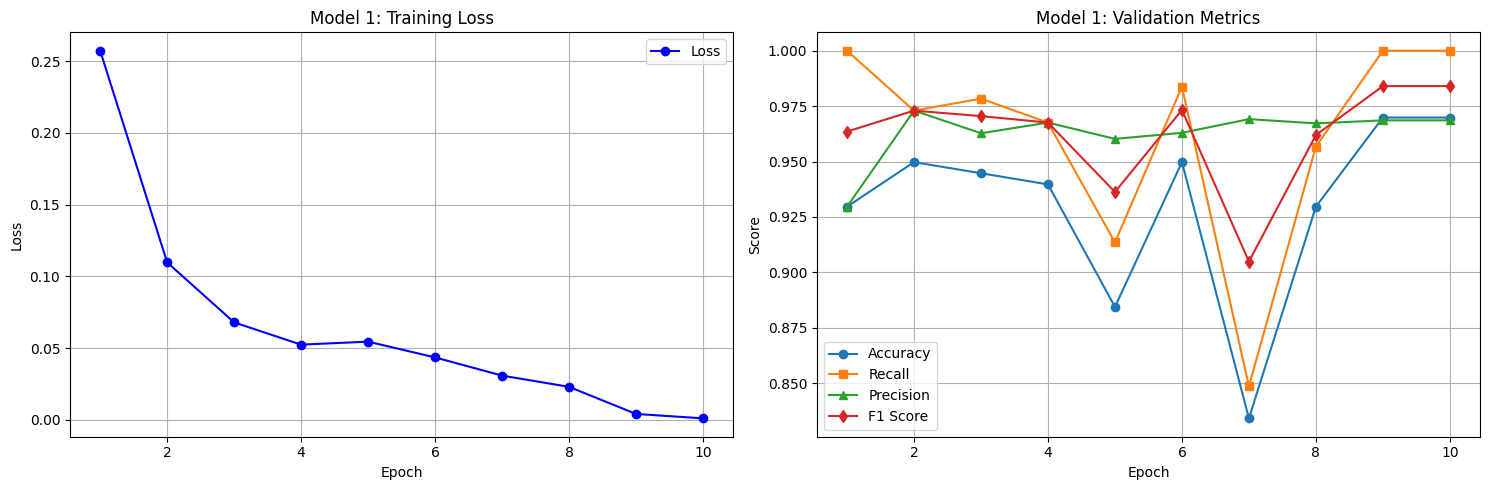

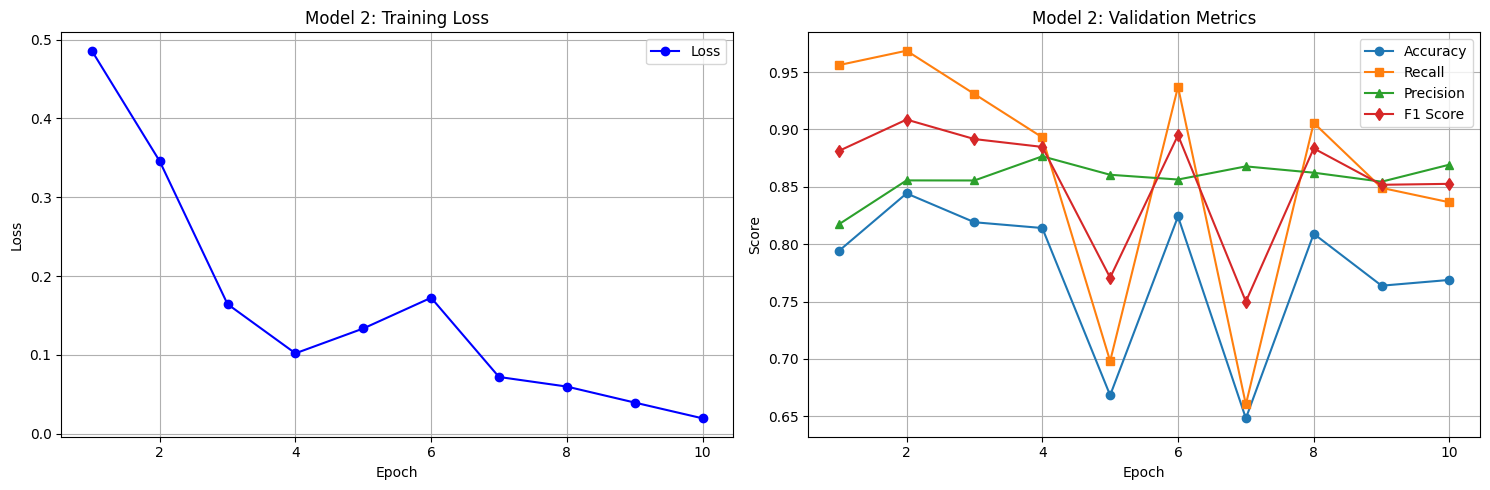

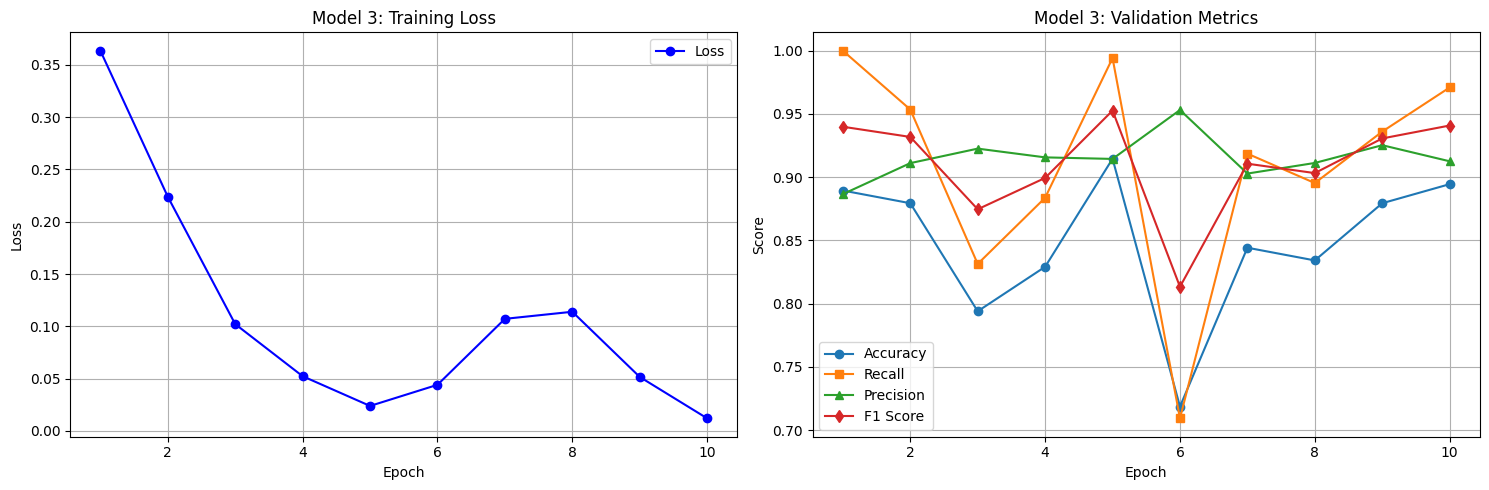

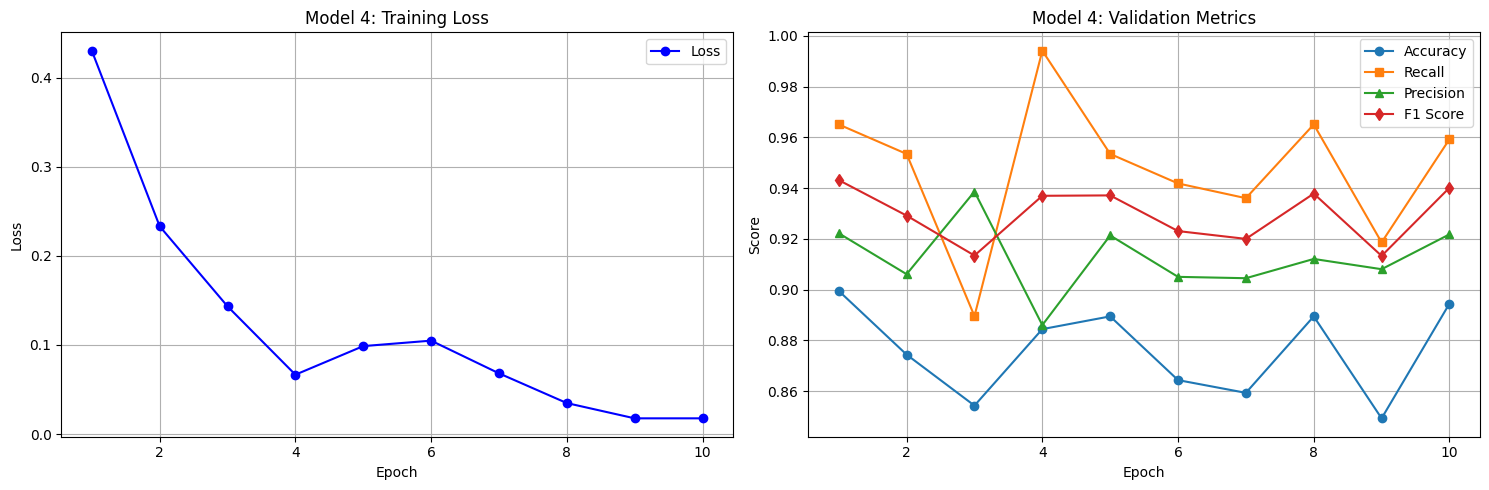

In [47]:
plot_all_models(results)


## Meta model

In [26]:
def collect_base_outputs(base_models, loader, device='cuda'):
    meta_inputs = []
    meta_labels = []
    all_images = []  # Store images for later use

    for batch_idx, (images, attribute_labels, final_labels) in enumerate(loader):
        print(f"Processing batch {batch_idx + 1}/{len(loader)}")
        
        # Move labels to GPU (images will be processed per model)
        final_labels = final_labels.to(device)
        all_images.append(images.cpu())  # Keep images on CPU for now
        
        # Collect outputs for all base models
        base_outputs = []
        for model_idx, model in enumerate(base_models):
            model = model.to(device)  # Ensure the model is on the device
            
            # Process images batch for this model
            with torch.no_grad():
                outputs = model(images.to(device)).detach().cpu()  # Compute and move to CPU
                base_outputs.append(outputs)
                print(f"Base model {model_idx + 1} outputs collected.")
        
        # Concatenate outputs for all base models
        base_outputs = torch.cat(base_outputs, dim=1)  # Concatenate all base outputs
        meta_inputs.append(base_outputs)  # Store only base outputs
        meta_labels.append(final_labels.cpu())  # Move labels to CPU
        
        # Clean up GPU memory after processing all models for the current batch
        del images, attribute_labels, final_labels, outputs, base_outputs
        torch.cuda.empty_cache()
    
    # Return the collected meta inputs, labels, and images
    return torch.cat(meta_inputs), torch.cat(meta_labels), torch.cat(all_images)


In [27]:

# Prepare meta-model training data
meta_inputs, meta_labels, images = collect_base_outputs(base_models, train_loader)

# Create a dataset with images, meta_inputs, and labels
meta_dataset = TensorDataset(images, meta_inputs, meta_labels)

# Use DataLoader with a smaller batch size
meta_loader = DataLoader(meta_dataset, batch_size=4, shuffle=True)


Processing batch 1/25
Base model 1 outputs collected.
Base model 2 outputs collected.
Base model 3 outputs collected.
Base model 4 outputs collected.
Processing batch 2/25
Base model 1 outputs collected.
Base model 2 outputs collected.
Base model 3 outputs collected.
Base model 4 outputs collected.
Processing batch 3/25
Base model 1 outputs collected.
Base model 2 outputs collected.
Base model 3 outputs collected.
Base model 4 outputs collected.
Processing batch 4/25
Base model 1 outputs collected.
Base model 2 outputs collected.
Base model 3 outputs collected.
Base model 4 outputs collected.
Processing batch 5/25
Base model 1 outputs collected.
Base model 2 outputs collected.
Base model 3 outputs collected.
Base model 4 outputs collected.
Processing batch 6/25
Base model 1 outputs collected.
Base model 2 outputs collected.
Base model 3 outputs collected.
Base model 4 outputs collected.
Processing batch 7/25
Base model 1 outputs collected.
Base model 2 outputs collected.
Base model 3 o

In [28]:
def train_meta_model(meta_model, meta_loader, meta_optimizer, criterion, device, num_epochs=10):
    """
    Train the meta-model and collect metrics for plotting.
    
    Args:
        meta_model: The meta-model to train.
        meta_loader: DataLoader for training and validation data.
        meta_optimizer: Optimizer for the meta-model.
        criterion: Loss function.
        device: Device to use for training (e.g., 'cuda' or 'cpu').
        num_epochs: Number of epochs to train for.

    Returns:
        results: A dictionary containing training losses and metrics for each epoch.
    """
    results = {"loss": [], "metrics": []}

    for epoch in range(num_epochs):
        # Training phase
        meta_model.train()
        total_loss = 0
        torch.cuda.empty_cache()  # Clean GPU memory
        
        for images, base_outputs, labels in meta_loader:  # Unpack all three elements
            images, base_outputs, labels = images.to(device), base_outputs.to(device), labels.to(device)

            meta_optimizer.zero_grad()
            outputs = meta_model(images, base_outputs).squeeze(-1)  # Pass both images and base_outputs
            loss = criterion(outputs, labels)
            loss.backward()
            meta_optimizer.step()

            total_loss += loss.item()
            torch.cuda.empty_cache()  # Clean GPU memory periodically
        
        avg_loss = total_loss / len(meta_loader)
        results["loss"].append(avg_loss)
        print(f"Meta Model Epoch {epoch+1}: Average Training Loss: {avg_loss:.4f}")

        # Validation phase
        meta_model.eval()
        all_labels = []
        all_predictions = []
        torch.cuda.empty_cache()  # Clean GPU memory
        
        with torch.no_grad():
            for images, base_outputs, labels in meta_loader:  # Unpack all three elements
                images, base_outputs, labels = images.to(device), base_outputs.to(device), labels.to(device)
                outputs = meta_model(images, base_outputs)  # Pass both images and base_outputs
                all_labels.append(labels.cpu())
                all_predictions.append(outputs.cpu())
                torch.cuda.empty_cache()  # Clean GPU memory periodically
        
        # Compute metrics
        all_labels = torch.cat(all_labels)
        all_predictions = torch.cat(all_predictions)
        metrics = compute_metrics(all_labels, all_predictions)
        results["metrics"].append(metrics)
        print(f"Meta Model Epoch {epoch+1}: Validation Metrics: {metrics}")

    return results


In [29]:
# Initialize the Meta Model
meta_model = MetaModel().to(device)  # Ensure the model is moved to the correct device

# Define optimizer and loss function
meta_optimizer = torch.optim.Adam(meta_model.parameters(), lr=1e-4)
criterion = nn.BCELoss()  # Binary Cross-Entropy Loss for binary classification

# Train the meta-model and collect results
results = train_meta_model(
    meta_model=meta_model,
    meta_loader=meta_loader,
    meta_optimizer=meta_optimizer,
    criterion=criterion,
    device=device,
    num_epochs=10
)

Meta Model Epoch 1: Average Training Loss: 0.5790
Meta Model Epoch 1: Validation Metrics: {'accuracy': 0.7566204287515763, 'recall': 0.9964726631393298, 'precision': 0.7473544973544973, 'f1': 0.8541194255479969}
Meta Model Epoch 2: Average Training Loss: 0.5249
Meta Model Epoch 2: Validation Metrics: {'accuracy': 0.7604035308953342, 'recall': 1.0, 'precision': 0.7490092470277411, 'f1': 0.8564954682779456}
Meta Model Epoch 3: Average Training Loss: 0.4712
Meta Model Epoch 3: Validation Metrics: {'accuracy': 0.8007566204287516, 'recall': 0.9982363315696648, 'precision': 0.7828492392807745, 'f1': 0.8775193798449612}
Meta Model Epoch 4: Average Training Loss: 0.3629
Meta Model Epoch 4: Validation Metrics: {'accuracy': 0.9205548549810845, 'recall': 0.9664902998236331, 'precision': 0.9256756756756757, 'f1': 0.9456427955133735}
Meta Model Epoch 5: Average Training Loss: 0.2534
Meta Model Epoch 5: Validation Metrics: {'accuracy': 0.9709962168978562, 'recall': 0.9682539682539683, 'precision': 0

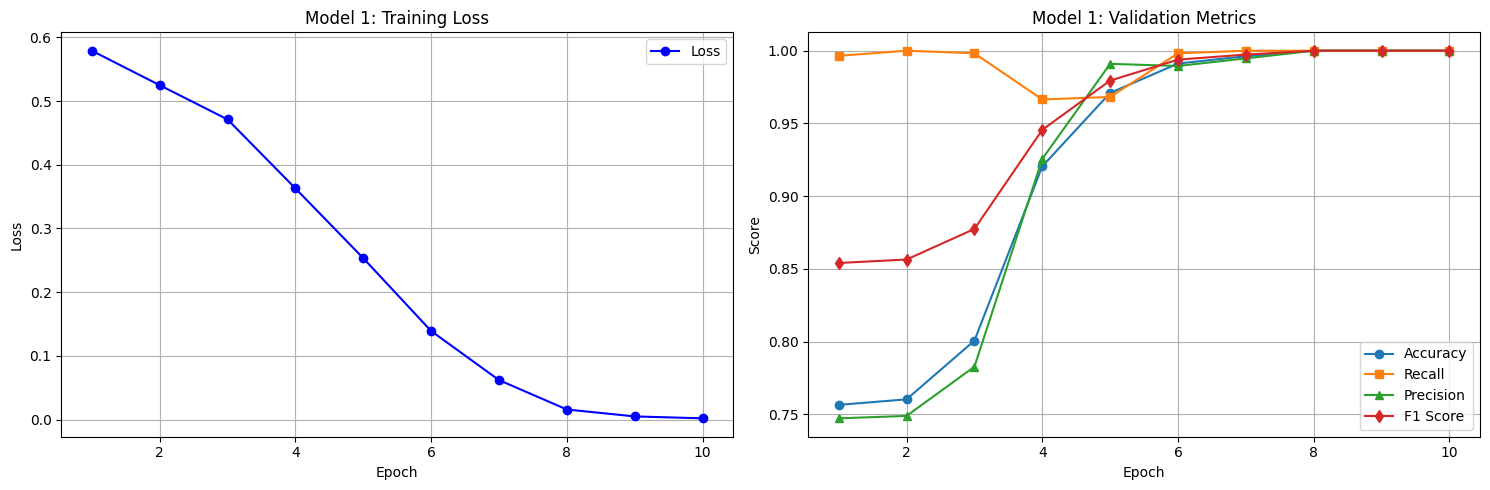

In [30]:
# Plot the training loss and metrics
plot_all_models([results])


In [31]:
print(meta_model)

MetaModel(
  (image_backbone): CustomCNN(
    (conv_layers): Sequential(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU()
      (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): ReLU()
      (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (6): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (7): ReLU()
      (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
    (fc): Sequential(
      (0): Flatten(start_dim=1, end_dim=-1)
      (1): Linear(in_features=115200, out_features=128, bias=True)
      (2): ReLU()
    )
  )
  (fc): Sequential(
    (0): Linear(in_features=132, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=1, bias=True)
  )
)


In [32]:

# import torch
# from torchviz import make_dot

# def visualize_model_architecture(model, example_inputs, file_name):
#     """
#     Visualizes the architecture of a given PyTorch model using torchviz.

#     Args:
#         model (torch.nn.Module): The PyTorch model to visualize.
#         example_inputs (tuple): Example inputs for the model's forward pass.
#         file_name (str): Name of the file to save the visualization (without extension).
#     """
#     model.eval()  # Set the model to evaluation mode
#     with torch.no_grad():
#         # Forward pass using the example inputs
#         if isinstance(example_inputs, tuple):
#             outputs = model(*example_inputs)
#         else:
#             outputs = model(example_inputs)

#     # Generate and save the computational graph
#     make_dot(outputs, params=dict(model.named_parameters())).render(file_name, format="png")
#     print(f"Model architecture saved as {file_name}.png")

# # Example usage for BaseModel
# def visualize_base_model():
#     base_model_example = BaseModel().to(device)
#     sample_input_base = torch.randn(1, 3, 240, 240).to(device)  # Example input for BaseModel
#     visualize_model_architecture(base_model_example, sample_input_base, "BaseModel_architecture")

# # Example usage for MetaModel
# def visualize_meta_model():
#     meta_model_example = MetaModel().to(device)
#     sample_image = torch.randn(1, 3, 240, 240).to(device)  # Example image input
#     sample_base_outputs = torch.randn(1, 4).to(device)  # Example outputs from 4 base models
#     visualize_model_architecture(meta_model_example, (sample_image, sample_base_outputs), "MetaModel_architecture")

# # Call the functions
# visualize_base_model()
# visualize_meta_model()


# Mobilenet models

In [45]:
from torchvision.models import mobilenet_v2

# Lightweight Base Model
class BaseModel(nn.Module):
    def __init__(self):
        super(BaseModel, self).__init__()
        self.backbone = mobilenet_v2(pretrained=True)
        self.backbone.classifier = nn.Linear(1280, 1)  # Single output per model

    def forward(self, x):
        return torch.sigmoid(self.backbone(x))  # Output probability for each class

# Initialize base models with MobileNetV2
device = 'cuda' if torch.cuda.is_available() else 'cpu'
base_models = [BaseModel().to(device) for _ in range(4)]

# Meta Model
class MetaModel(nn.Module):
    def __init__(self):
        super(MetaModel, self).__init__()
        # Convolutional backbone for the image input
        self.image_backbone = mobilenet_v2(pretrained=True)
        self.image_backbone.classifier = nn.Linear(1280, 128)  # Feature vector for the image
        
        # Fully connected layers to combine image features and base model outputs
        self.fc = nn.Sequential(
            nn.Linear(128 + 4, 64),  # 128 (image features) + 4 (base model outputs)
            nn.ReLU(),
            nn.Linear(64, 1)  # Output: Final decision
        )

    def forward(self, image, base_outputs):
        # Extract features from the image
        image_features = self.image_backbone(image)  # Shape: [batch_size, 128]
        
        # Concatenate image features and base model outputs
        combined = torch.cat([image_features, base_outputs], dim=1)  # Shape: [batch_size, 128 + 4]
        
        # Predict final decision
        return torch.sigmoid(self.fc(combined))  # Output probability


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [46]:
results = train_and_evaluate(
    base_models=base_models,
    train_loader=train_loader,
    val_loader=val_loader,
    device=device,
    epochs=10,
    lr=0.001
)


Base Model 1, Epoch 1: Loss: 0.2572, Metrics: {'accuracy': 0.9296482412060302, 'recall': 1.0, 'precision': 0.9296482412060302, 'f1': 0.9635416666666667}
Base Model 1, Epoch 2: Loss: 0.1097, Metrics: {'accuracy': 0.949748743718593, 'recall': 0.972972972972973, 'precision': 0.972972972972973, 'f1': 0.972972972972973}
Base Model 1, Epoch 3: Loss: 0.0679, Metrics: {'accuracy': 0.9447236180904522, 'recall': 0.9783783783783784, 'precision': 0.9627659574468085, 'f1': 0.9705093833780161}
Base Model 1, Epoch 4: Loss: 0.0524, Metrics: {'accuracy': 0.9396984924623115, 'recall': 0.9675675675675676, 'precision': 0.9675675675675676, 'f1': 0.9675675675675676}
Base Model 1, Epoch 5: Loss: 0.0545, Metrics: {'accuracy': 0.8844221105527639, 'recall': 0.9135135135135135, 'precision': 0.9602272727272727, 'f1': 0.9362880886426592}
Base Model 1, Epoch 6: Loss: 0.0435, Metrics: {'accuracy': 0.949748743718593, 'recall': 0.9837837837837838, 'precision': 0.9629629629629629, 'f1': 0.9732620320855615}
Base Model 1

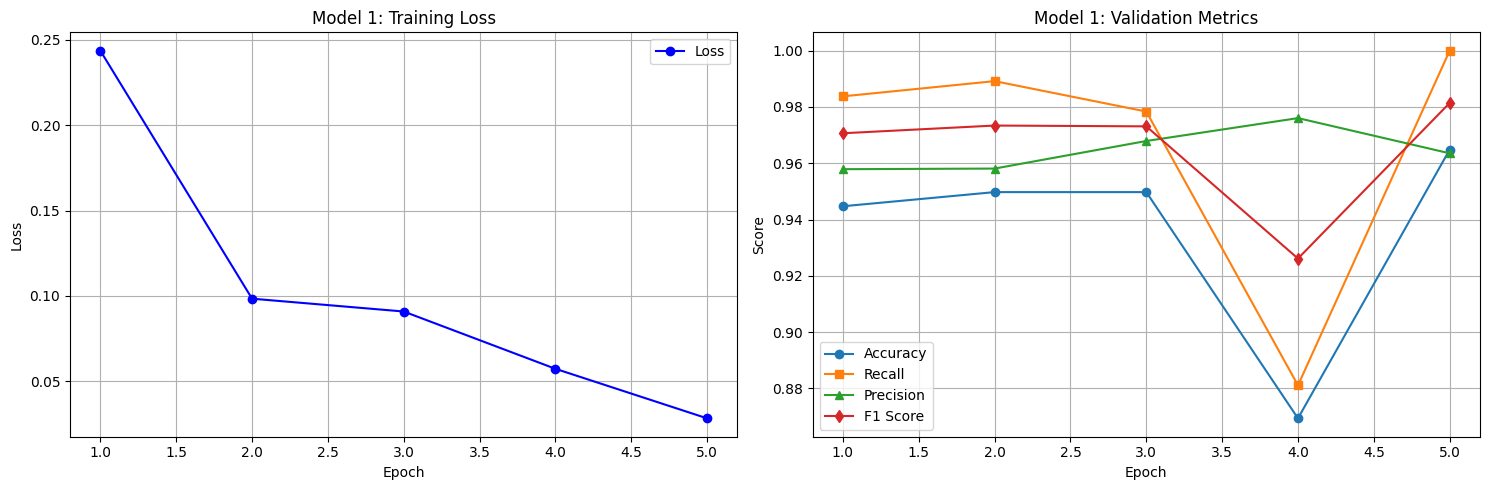

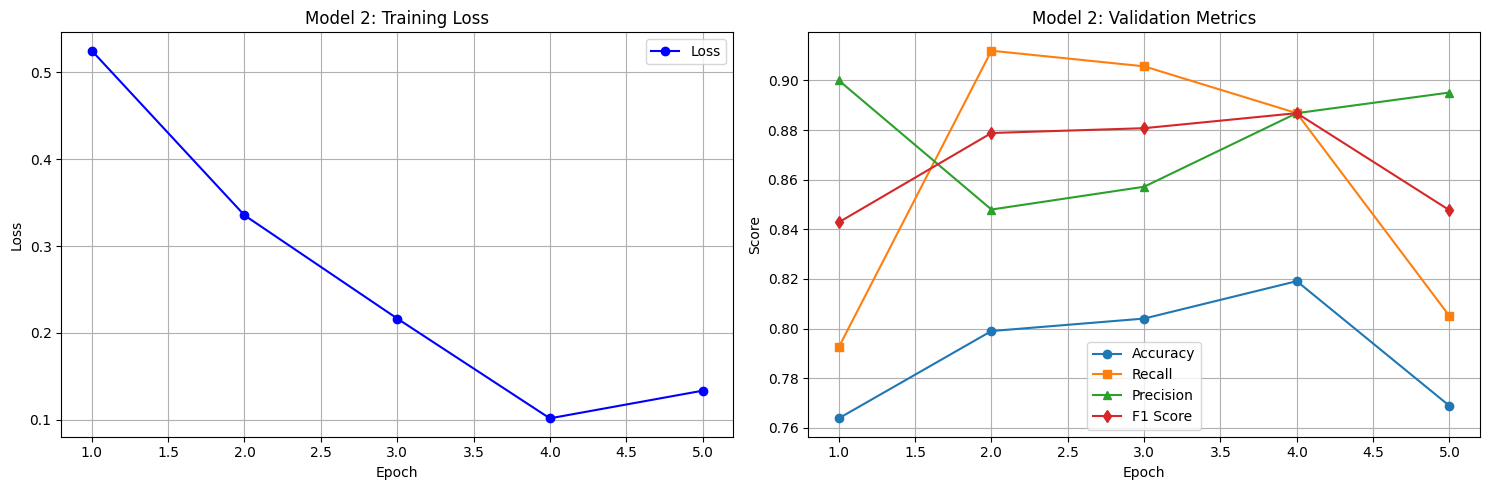

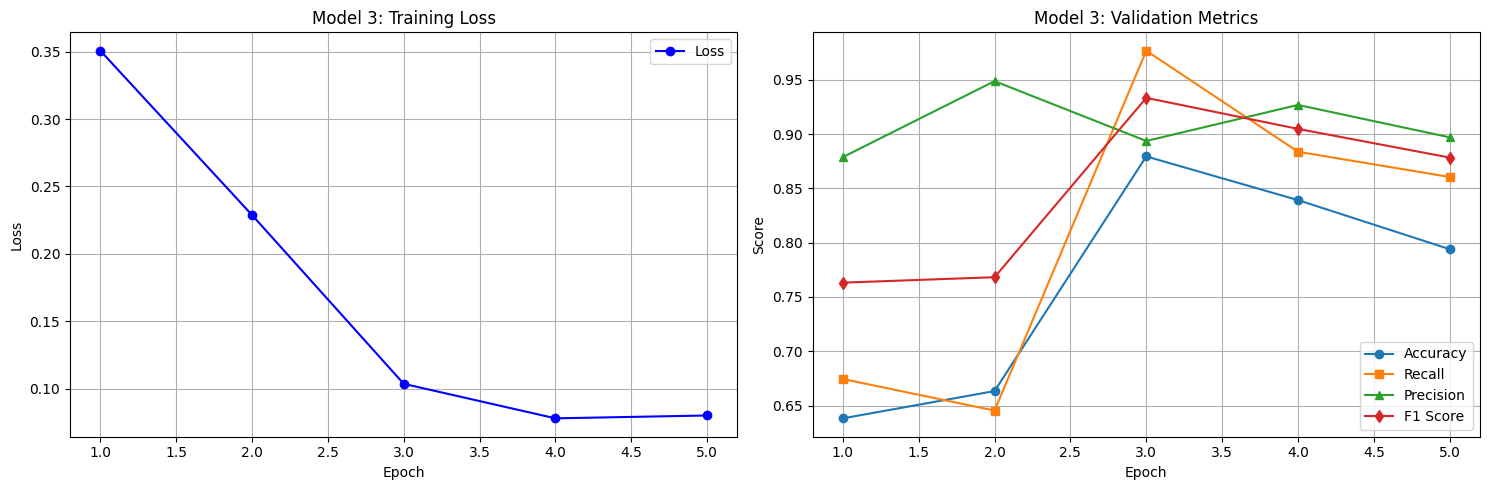

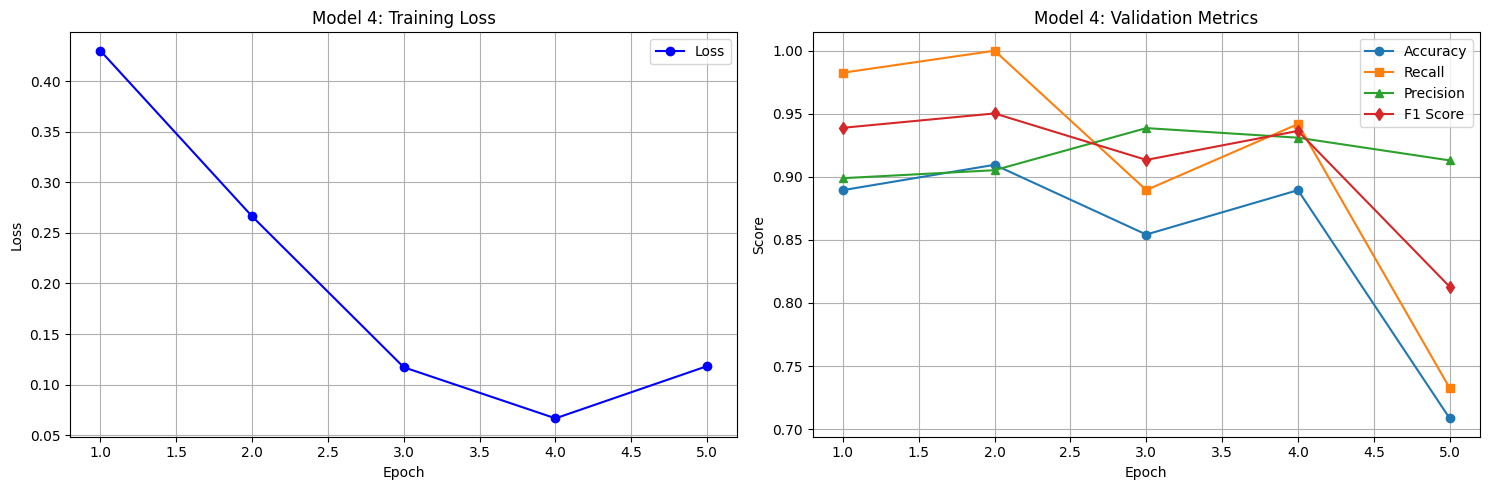

In [35]:
plot_all_models(results)

In [36]:
def collect_base_outputs(base_models, loader, device='cuda'):
    meta_inputs = []
    meta_labels = []
    all_images = []  # Store images for later use

    for batch_idx, (images, attribute_labels, final_labels) in enumerate(loader):
        print(f"Processing batch {batch_idx + 1}/{len(loader)}")
        
        # Move labels to GPU (images will be processed per model)
        final_labels = final_labels.to(device)
        all_images.append(images.cpu())  # Keep images on CPU for now
        
        # Collect outputs for all base models
        base_outputs = []
        for model_idx, model in enumerate(base_models):
            model = model.to(device)  # Ensure the model is on the device
            
            # Process images batch for this model
            with torch.no_grad():
                outputs = model(images.to(device)).detach().cpu()  # Compute and move to CPU
                base_outputs.append(outputs)
                print(f"Base model {model_idx + 1} outputs collected.")
        
        # Concatenate outputs for all base models
        base_outputs = torch.cat(base_outputs, dim=1)  # Concatenate all base outputs
        meta_inputs.append(base_outputs)  # Store only base outputs
        meta_labels.append(final_labels.cpu())  # Move labels to CPU
        
        # Clean up GPU memory after processing all models for the current batch
        del images, attribute_labels, final_labels, outputs, base_outputs
        torch.cuda.empty_cache()
    
    # Return the collected meta inputs, labels, and images
    return torch.cat(meta_inputs), torch.cat(meta_labels), torch.cat(all_images)


In [37]:

# Prepare meta-model training data
meta_inputs, meta_labels, images = collect_base_outputs(base_models, train_loader)

# Create a dataset with images, meta_inputs, and labels
meta_dataset = TensorDataset(images, meta_inputs, meta_labels)

# Use DataLoader with a smaller batch size
meta_loader = DataLoader(meta_dataset, batch_size=4, shuffle=True)


Processing batch 1/25
Base model 1 outputs collected.
Base model 2 outputs collected.
Base model 3 outputs collected.
Base model 4 outputs collected.
Processing batch 2/25
Base model 1 outputs collected.
Base model 2 outputs collected.
Base model 3 outputs collected.
Base model 4 outputs collected.
Processing batch 3/25
Base model 1 outputs collected.
Base model 2 outputs collected.
Base model 3 outputs collected.
Base model 4 outputs collected.
Processing batch 4/25
Base model 1 outputs collected.
Base model 2 outputs collected.
Base model 3 outputs collected.
Base model 4 outputs collected.
Processing batch 5/25
Base model 1 outputs collected.
Base model 2 outputs collected.
Base model 3 outputs collected.
Base model 4 outputs collected.
Processing batch 6/25
Base model 1 outputs collected.
Base model 2 outputs collected.
Base model 3 outputs collected.
Base model 4 outputs collected.
Processing batch 7/25
Base model 1 outputs collected.
Base model 2 outputs collected.
Base model 3 o

In [42]:
# Initialize the Meta Model
meta_model = MetaModel().to(device)  # Ensure the model is moved to the correct device

# Define optimizer and loss function
meta_optimizer = torch.optim.Adam(meta_model.parameters(), lr=1e-4)
criterion = nn.BCELoss()  # Binary Cross-Entropy Loss for binary classification

# Train the meta-model and collect results
results = train_meta_model(
    meta_model=meta_model,
    meta_loader=meta_loader,
    meta_optimizer=meta_optimizer,
    criterion=criterion,
    device=device,
    num_epochs=10
)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Meta Model Epoch 1: Average Training Loss: 0.5530
Meta Model Epoch 1: Validation Metrics: {'accuracy': 0.8549810844892812, 'recall': 0.9523809523809523, 'precision': 0.8598726114649682, 'f1': 0.903765690376569}
Meta Model Epoch 2: Average Training Loss: 0.4387
Meta Model Epoch 2: Validation Metrics: {'accuracy': 0.9369482976040353, 'recall': 0.9770723104056437, 'precision': 0.937394247038917, 'f1': 0.9568221070811743}
Meta Model Epoch 3: Average Training Loss: 0.2976
Meta Model Epoch 3: Validation Metrics: {'accuracy': 0.9394703656998739, 'recall': 0.9400352733686067, 'precision': 0.9744058500914077, 'f1': 0.9569120287253142}
Meta Model Epoch 4: Average Training Loss: 0.2320
Meta Model Epoch 4: Validation Metrics: {'accuracy': 0.9823455233291298, 'recall': 0.9788359788359788, 'precision': 0.9964093357271095, 'f1': 0.9875444839857651}
Meta Model Epoch 5: Average Training Loss: 0.1799
Meta Model Epoch 5: Validation Metrics: {'accuracy': 0.9735182849936949, 'recall': 0.9647266313932981, '

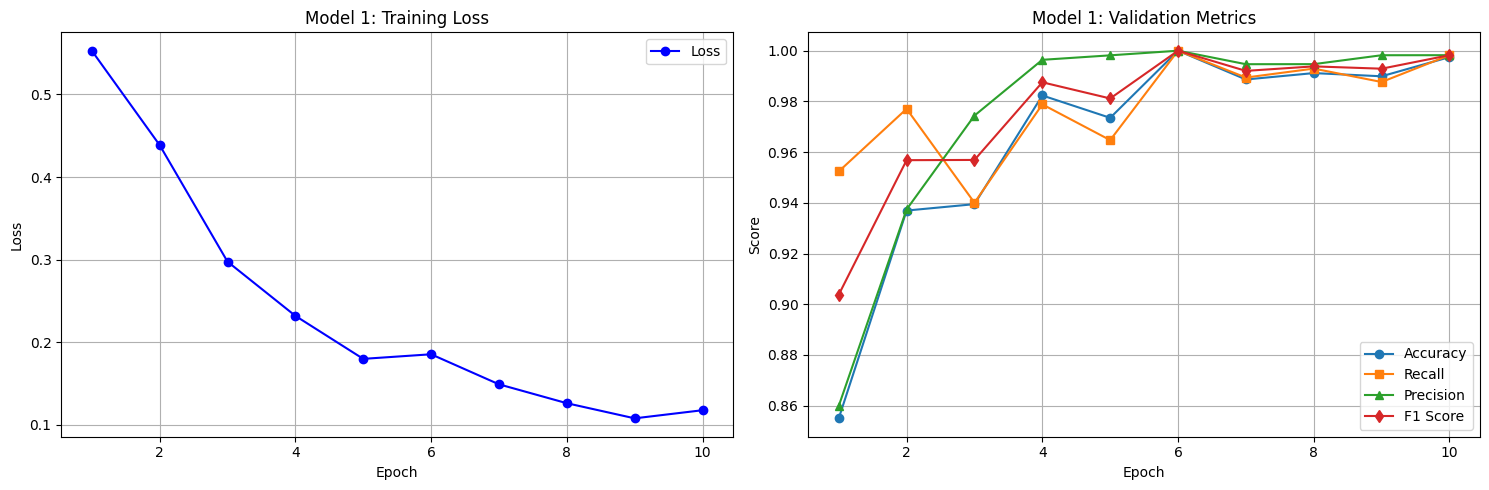

In [43]:
plot_all_models([results])


In [ ]:
t

# Resnet18

In [ ]:
from torchvision.models import resnet18

class BaseModel(nn.Module):
    def __init__(self):
        super(BaseModel, self).__init__()
        self.backbone = resnet18(pretrained=True)
        self.backbone.fc = nn.Linear(512, 1)  # Single output per model

    def forward(self, x):
        return torch.sigmoid(self.backbone(x))  # Output probability for each class

# Initialize base models
base_models = [BaseModel().to(device) for _ in range(4)]


In [ ]:
class MetaModel(nn.Module):
    def __init__(self):
        super(MetaModel, self).__init__()
        # Convolutional backbone for the image input
        self.image_backbone = resnet18(pretrained=True)
        self.image_backbone.fc = nn.Linear(512, 128)  # Feature vector for the image
        
        # Fully connected layers to combine image features and base model outputs
        self.fc = nn.Sequential(
            nn.Linear(128 + 4, 64),  # 128 (image features) + 4 (base model outputs)
            nn.ReLU(),
            nn.Linear(64, 1)  # Output: Final decision
        )

    def forward(self, image, base_outputs):
        # Extract features from the image
        image_features = self.image_backbone(image)  # Shape: [batch_size, 128]
        
        # Concatenate image features and base model outputs
        combined = torch.cat([image_features, base_outputs], dim=1)  # Shape: [batch_size, 128 + 4]
        
        # Predict final decision
        return torch.sigmoid(self.fc(combined))  # Output probability


In [ ]:
from torchvision.models import mobilenet_v2
import torch.nn as nn
import torch

# Lightweight Base Model
class BaseModel(nn.Module):
    def __init__(self):
        super(BaseModel, self).__init__()
        self.backbone = mobilenet_v2(pretrained=True)
        self.backbone.classifier = nn.Linear(1280, 1)  # Single output per model

    def forward(self, x):
        return torch.sigmoid(self.backbone(x))  # Output probability for each class

# Initialize base models with MobileNetV2
device = 'cuda' if torch.cuda.is_available() else 'cpu'
base_models = [BaseModel().to(device) for _ in range(4)]

# Meta Model
class MetaModel(nn.Module):
    def __init__(self):
        super(MetaModel, self).__init__()
        # Convolutional backbone for the image input
        self.image_backbone = mobilenet_v2(pretrained=True)
        self.image_backbone.classifier = nn.Linear(1280, 128)  # Feature vector for the image
        
        # Fully connected layers to combine image features and base model outputs
        self.fc = nn.Sequential(
            nn.Linear(128 + 4, 64),  # 128 (image features) + 4 (base model outputs)
            nn.ReLU(),
            nn.Linear(64, 1)  # Output: Final decision
        )

    def forward(self, image, base_outputs):
        # Extract features from the image
        image_features = self.image_backbone(image)  # Shape: [batch_size, 128]
        
        # Concatenate image features and base model outputs
        combined = torch.cat([image_features, base_outputs], dim=1)  # Shape: [batch_size, 128 + 4]
        
        # Predict final decision
        return torch.sigmoid(self.fc(combined))  # Output probability


In [ ]:
# Define the loss function (criterion)
criterion = nn.BCELoss()  # Binary Cross-Entropy Loss for binary classification

# Train each base model and compute metrics
for i, base_model in enumerate(base_models):
    optimizer = torch.optim.Adam(base_model.parameters(), lr=0.001)
    for epoch in range(5):
        base_model.train()
        running_loss = 0.0  # To accumulate loss for the epoch
        for batch_idx, (images, attribute_labels, _) in enumerate(train_loader):
            # Move data to GPU
            images, attribute_labels = images.to(device), attribute_labels.to(device)
            labels = attribute_labels[:, i:i+1]  # Select the i-th attribute column
            
            optimizer.zero_grad()
            outputs = base_model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            # Accumulate loss
            running_loss += loss.item()
            if (batch_idx + 1) % 10 == 0:  # Print every 10 batches
                print(f"Base Model {i+1}, Epoch {epoch+1}, Batch {batch_idx+1}: Loss: {loss.item():.4f}")
            
            # Offload data from GPU, but keep the model on GPU
            del images, attribute_labels, labels, outputs
            torch.cuda.empty_cache()
        
        avg_loss = running_loss / len(train_loader)
        print(f"Base Model {i+1}, Epoch {epoch+1}: Average Training Loss: {avg_loss:.4f}")
        
        # Evaluate metrics on validation set
        base_model.eval()
        all_labels = []
        all_predictions = []
        with torch.no_grad():
            for images, attribute_labels, _ in val_loader:
                # Move data to GPU
                images, attribute_labels = images.to(device), attribute_labels.to(device)
                labels = attribute_labels[:, i:i+1]
                outputs = base_model(images)
                
                # Collect outputs and labels
                all_labels.append(labels.cpu())  # Move to CPU
                all_predictions.append(outputs.cpu())  # Move to CPU

                # Offload data from GPU
                del images, attribute_labels, labels, outputs
                torch.cuda.empty_cache()
        
        # Concatenate and compute metrics
        all_labels = torch.cat(all_labels)
        all_predictions = torch.cat(all_predictions)
        metrics = compute_metrics(all_labels, all_predictions)
        
        print(f"Base Model {i+1}, Epoch {epoch+1}: Validation Metrics: {metrics}")


In [ ]:
def clean_gpu_memory():
    """
    Cleans GPU memory by deleting unused variables and clearing the PyTorch CUDA cache.
    """
    torch.cuda.empty_cache()  # Clears the cache
    torch.cuda.synchronize()  # Ensures all operations are completed before releasing memory
    print("GPU memory cleaned successfully!")

# # Example usage
# clean_gpu_memory()

In [ ]:
# def collect_base_outputs(base_models, loader, device='cuda'):
#     meta_inputs = []
#     meta_labels = []
    
#     for batch_idx, (images, attribute_labels, final_labels) in enumerate(loader):
#         print(f"Processing batch {batch_idx + 1}/{len(loader)}")
        
#         # Move images and labels to GPU
#         images = images.to(device)
#         final_labels = final_labels.to(device)
        
#         # Compute outputs for each base model and move to CPU
#         base_outputs = []
#         for model_idx, model in enumerate(base_models):
#             with torch.no_grad():
#                 outputs = model(images).detach().cpu()  # Compute and move to CPU
#                 base_outputs.append(outputs)
#                 print(f"Base model {model_idx + 1} outputs collected.")
        
#         # Concatenate outputs and store them
#         base_outputs = torch.cat(base_outputs, dim=1)  # Concatenate all base outputs
#         meta_inputs.append(base_outputs)  # Store only base outputs
#         meta_labels.append(final_labels.cpu())  # Move labels to CPU
        
#         # Clean up GPU memory
#         del images, final_labels, outputs, base_outputs
#         torch.cuda.empty_cache()  # Free memory
    
#     # Return the collected meta inputs and labels
#     return torch.cat(meta_inputs), torch.cat(meta_labels)


In [ ]:
# # Prepare meta-model training data
# meta_inputs, meta_labels = collect_base_outputs(base_models, train_loader)

# # Create a dataset from meta inputs and labels
# meta_dataset = TensorDataset(meta_inputs, meta_labels)

# # Use DataLoader with a smaller batch size
# meta_loader = DataLoader(meta_dataset, batch_size=4, shuffle=True)


In [ ]:
# from torch.utils.data import TensorDataset, DataLoader

# def collect_base_outputs(base_models, loader, device='cuda'):
#     meta_inputs = []
#     meta_labels = []
    
#     for batch_idx, (images, attribute_labels, final_labels) in enumerate(loader):
#         print(f"Processing batch {batch_idx + 1}/{len(loader)}")
        
#         # Move labels to GPU (images will be processed per model)
#         final_labels = final_labels.to(device)
        
#         # Collect outputs for all base models
#         base_outputs = []
#         for model_idx, model in enumerate(base_models):
#             model = model.to(device)  # Ensure the model is on the device
            
#             # Process images batch for this model
#             with torch.no_grad():
#                 outputs = model(images.to(device)).detach().cpu()  # Compute and move to CPU
#                 base_outputs.append(outputs)
#                 print(f"Base model {model_idx + 1} outputs collected.")
        
#         # Concatenate outputs for all base models
#         base_outputs = torch.cat(base_outputs, dim=1)  # Concatenate all base outputs
#         meta_inputs.append(base_outputs)  # Store only base outputs
#         meta_labels.append(final_labels.cpu())  # Move labels to CPU
        
#         # Clean up GPU memory after processing all models for the current batch
#         del images, attribute_labels, final_labels, outputs, base_outputs
#         torch.cuda.empty_cache()
    
#     # Return the collected meta inputs and labels
#     return torch.cat(meta_inputs), torch.cat(meta_labels)

# # Prepare meta-model training data
# meta_inputs, meta_labels = collect_base_outputs(base_models, train_loader)

# # Create a dataset from meta inputs and labels
# meta_dataset = TensorDataset(meta_inputs, meta_labels)

# # Use DataLoader with a smaller batch size
# meta_loader = DataLoader(meta_dataset, batch_size=4, shuffle=True)

# # Initialize the meta-model
# meta_model = MetaModel().to(device)

# # Define the optimizer and criterion for the meta-model
# meta_optimizer = torch.optim.Adam(meta_model.parameters(), lr=0.001)
# criterion = torch.nn.BCELoss()  # Binary Cross-Entropy Loss, since we are using sigmoid


# # Train the meta-model and compute metrics
# for epoch in range(10):
#     meta_model.train()
#     total_loss = 0
#     # Clean GPU memory before starting the epoch
#     torch.cuda.empty_cache()  
    
#     for (images, base_outputs), labels in meta_loader:
#         images, base_outputs, labels = images.to(device), base_outputs.to(device), labels.to(device)
        
#         meta_optimizer.zero_grad()
#         outputs = meta_model(images, base_outputs)
#         loss = criterion(outputs, labels)
#         loss.backward()
#         meta_optimizer.step()
        
#         total_loss += loss.item()
        
#         # Clean GPU memory periodically within each epoch
#         torch.cuda.empty_cache()
    
#     avg_loss = total_loss / len(meta_loader)
#     print(f"Meta Model Epoch {epoch+1}: Average Training Loss: {avg_loss:.4f}")
    
#     # Evaluate metrics on validation set
#     meta_model.eval()
#     all_labels = []
#     all_predictions = []
#     # Clean GPU memory before validation
#     torch.cuda.empty_cache()  
    
#     with torch.no_grad():
#         for (images, base_outputs), labels in meta_loader:
#             images, base_outputs, labels = images.to(device), base_outputs.to(device), labels.to(device)
#             outputs = meta_model(images, base_outputs)
#             all_labels.append(labels.cpu())
#             all_predictions.append(outputs.cpu())
            
#             # Clean GPU memory periodically during validation
#             torch.cuda.empty_cache()
    
#     # Concatenate and compute metrics
#     all_labels = torch.cat(all_labels)
#     all_predictions = torch.cat(all_predictions)
#     metrics = compute_metrics(all_labels, all_predictions)
#     print(f"Meta Model Epoch {epoch+1}: Validation Metrics: {metrics}")


In [ ]:
def collect_base_outputs(base_models, loader, device='cuda'):
    meta_inputs = []
    meta_labels = []
    all_images = []  # Store images for later use

    for batch_idx, (images, attribute_labels, final_labels) in enumerate(loader):
        print(f"Processing batch {batch_idx + 1}/{len(loader)}")
        
        # Move labels to GPU (images will be processed per model)
        final_labels = final_labels.to(device)
        all_images.append(images.cpu())  # Keep images on CPU for now
        
        # Collect outputs for all base models
        base_outputs = []
        for model_idx, model in enumerate(base_models):
            model = model.to(device)  # Ensure the model is on the device
            
            # Process images batch for this model
            with torch.no_grad():
                outputs = model(images.to(device)).detach().cpu()  # Compute and move to CPU
                base_outputs.append(outputs)
                print(f"Base model {model_idx + 1} outputs collected.")
        
        # Concatenate outputs for all base models
        base_outputs = torch.cat(base_outputs, dim=1)  # Concatenate all base outputs
        meta_inputs.append(base_outputs)  # Store only base outputs
        meta_labels.append(final_labels.cpu())  # Move labels to CPU
        
        # Clean up GPU memory after processing all models for the current batch
        del images, attribute_labels, final_labels, outputs, base_outputs
        torch.cuda.empty_cache()
    
    # Return the collected meta inputs, labels, and images
    return torch.cat(meta_inputs), torch.cat(meta_labels), torch.cat(all_images)


In [ ]:
# Prepare meta-model training data
meta_inputs, meta_labels, images = collect_base_outputs(base_models, train_loader)

# Create a dataset with images, meta_inputs, and labels
meta_dataset = TensorDataset(images, meta_inputs, meta_labels)

# Use DataLoader with a smaller batch size
meta_loader = DataLoader(meta_dataset, batch_size=4, shuffle=True)


In [ ]:
def collect_base_outputs(base_models, loader, device='cuda'):
    meta_inputs = []
    meta_labels = []
    all_images = []  # Store images for later use

    for batch_idx, (images, attribute_labels, final_labels) in enumerate(loader):
        print(f"Processing batch {batch_idx + 1}/{len(loader)}")
        
        # Move labels to GPU (images will be processed per model)
        final_labels = final_labels.to(device)
        all_images.append(images.cpu())  # Keep images on CPU for now
        
        # Collect outputs for all base models
        base_outputs = []
        for model_idx, model in enumerate(base_models):
            model = model.to(device)  # Ensure the model is on the device
            
            # Process images batch for this model
            with torch.no_grad():
                outputs = model(images.to(device)).detach().cpu()  # Compute and move to CPU
                base_outputs.append(outputs)
                print(f"Base model {model_idx + 1} outputs collected.")
        
        # Concatenate outputs for all base models
        base_outputs = torch.cat(base_outputs, dim=1)  # Concatenate all base outputs
        meta_inputs.append(base_outputs)  # Store only base outputs
        meta_labels.append(final_labels.cpu())  # Move labels to CPU
        
        # Clean up GPU memory after processing all models for the current batch
        del images, attribute_labels, final_labels, outputs, base_outputs
        torch.cuda.empty_cache()
    
    # Return the collected meta inputs, labels, and images
    return torch.cat(meta_inputs), torch.cat(meta_labels), torch.cat(all_images)


In [ ]:
# Train the meta-model and compute metrics
for epoch in range(10):
    meta_model.train()
    total_loss = 0
    # Clean GPU memory before starting the epoch
    torch.cuda.empty_cache()
    
    for images, base_outputs, labels in meta_loader:  # Unpack all three elements
        images, base_outputs, labels = images.to(device), base_outputs.to(device), labels.to(device)
        
        meta_optimizer.zero_grad()
        outputs = meta_model(images, base_outputs).squeeze(-1)   # Pass both images and base_outputs
        loss = criterion(outputs, labels)
        loss.backward()
        meta_optimizer.step()
        
        total_loss += loss.item()
        
        # Clean GPU memory periodically within each epoch
        torch.cuda.empty_cache()
    
    avg_loss = total_loss / len(meta_loader)
    print(f"Meta Model Epoch {epoch+1}: Average Training Loss: {avg_loss:.4f}")
    
    # Evaluate metrics on validation set
    meta_model.eval()
    all_labels = []
    all_predictions = []
    # Clean GPU memory before validation
    torch.cuda.empty_cache()
    
    with torch.no_grad():
        for images, base_outputs, labels in meta_loader:  # Unpack all three elements
            images, base_outputs, labels = images.to(device), base_outputs.to(device), labels.to(device)
            outputs = meta_model(images, base_outputs)  # Pass both images and base_outputs
            all_labels.append(labels.cpu())
            all_predictions.append(outputs.cpu())
            
            # Clean GPU memory periodically during validation
            torch.cuda.empty_cache()
    
    # Concatenate and compute metrics
    all_labels = torch.cat(all_labels)
    all_predictions = torch.cat(all_predictions)
    metrics = compute_metrics(all_labels, all_predictions)
    print(f"Meta Model Epoch {epoch+1}: Validation Metrics: {metrics}")
